In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, f1_score

#synthetic data
np.random.seed(0)
data_size = 1000

#features and classess
data = pd.DataFrame({
    'age': np.random.randint(18, 70, data_size),
    'income': np.random.normal(50000, 20000, data_size),
    'loan_amount': np.random.normal(15000, 7000, data_size),
    'loan_duration': np.random.randint(12, 60, data_size),
    'credit_score': np.random.normal(700, 50, data_size),
    'employment_status': np.random.choice([0, 1], data_size, p=[0.35, 0.65]),  # 0: Unemployed, 1: Employed
    'default': np.random.choice([0, 1], data_size, p=[0.7, 0.3])  # 0: No default, 1: Default
})
data.head()


,age,income,loan_amount,loan_duration,credit_score,employment_status,default
0,62,45691.608902,18880.275320,19,705.116792,1,1
1,65,59615.222863,22081.492466,49,688.795382,1,1
2,18,84103.734393,14372.912454,57,798.386484,0,1
3,21,25194.824022,12103.241861,32,722.384161,1,0
4,21,46723.721498,10302.955298,12,666.890428,0,1


In [14]:
# missing values filling
data.fillna(data.median(), inplace=True)

# handle outliers using IQR
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

# feature scaling
scaler = StandardScaler()
features = data.drop('default', axis=1)
target = data['default']
features_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

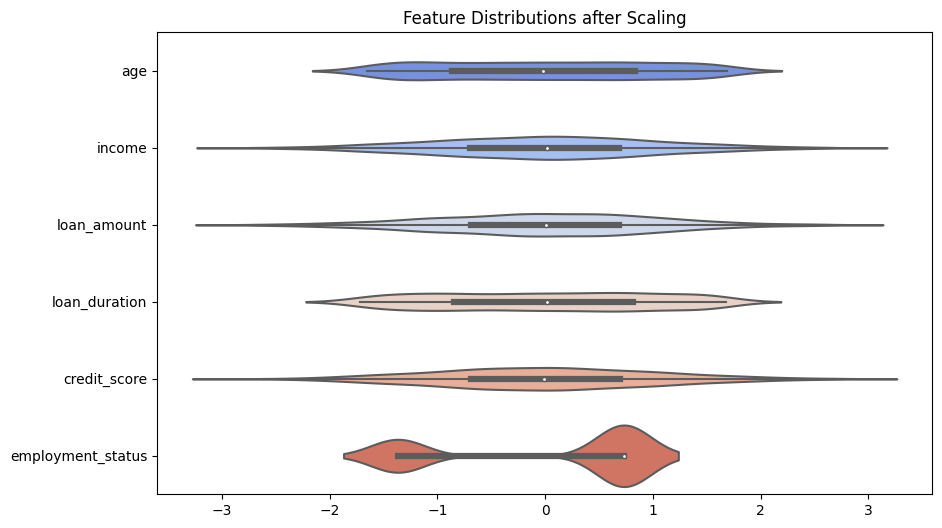

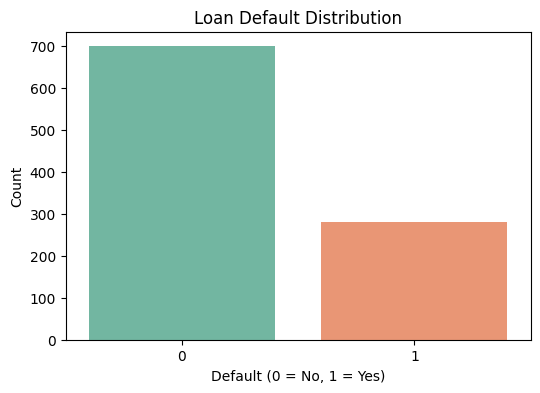

In [15]:
#eda
plt.figure(figsize=(10, 6))
sns.violinplot(data=features_scaled, orient='h', palette='coolwarm')  # Changed to violin plot
plt.title('Feature Distributions after Scaling')
plt.show()

#target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=target, palette='Set2')
plt.title('Loan Default Distribution')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


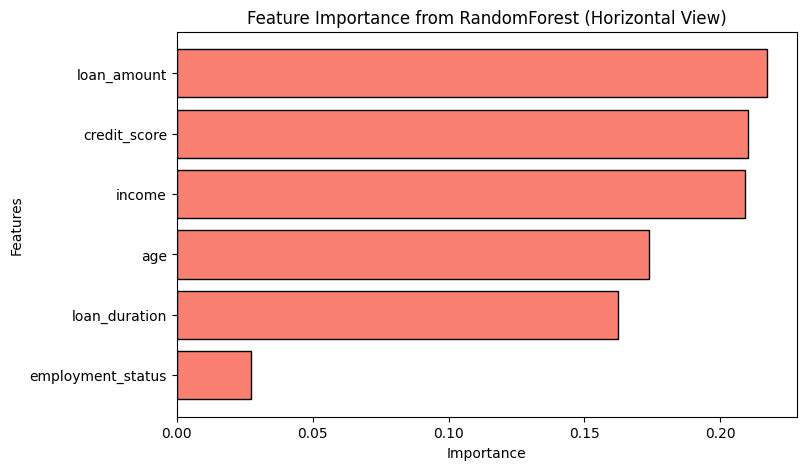

In [16]:
# RandomForest
model_rf = RandomForestClassifier(random_state=0)
model_rf.fit(features_scaled, target)

#feature importances plotting
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(features_scaled.shape[1]), importances[indices], color='salmon', edgecolor='black')
plt.yticks(range(features_scaled.shape[1]), features_scaled.columns[indices])
plt.title('Feature Importance from RandomForest (Horizontal View)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


In [17]:
#model
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=0)
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1] if len(model.classes_) > 1 else model.predict(X_test)  # Fix for predict_proba


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.93      0.80       210
           1       0.22      0.05      0.08        85

    accuracy                           0.68       295
   macro avg       0.46      0.49      0.44       295
weighted avg       0.57      0.68      0.60       295

F1 Score: 0.08
ROC-AUC Score: 0.48


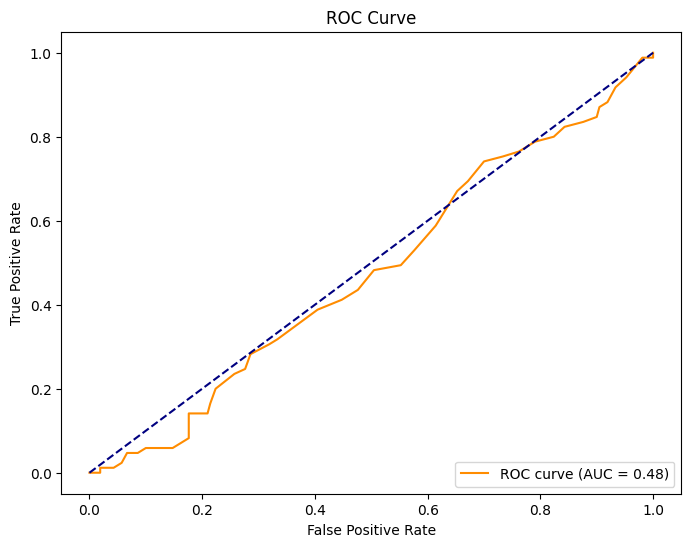

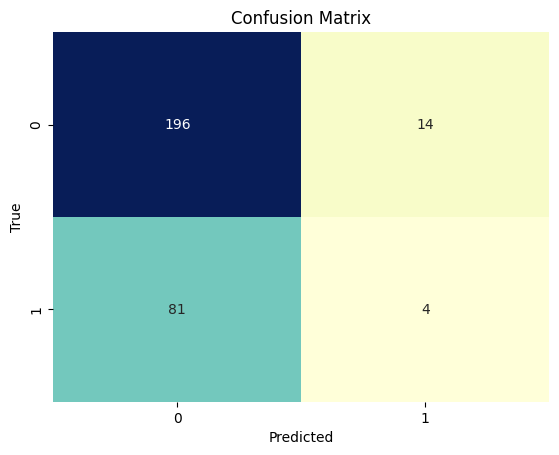

In [18]:
#evalution
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba) if len(model.classes_) > 1 else 0.5  # Check for ROC-AUC calculation

# classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"F1 Score: {f1:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}" if len(model.classes_) > 1 else "ROC-AUC Score: Not applicable")

# ROC Curve
if len(model.classes_) > 1:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



### Conclusion
This notebook demonstrates the end-to-end process for predicting loan default probabilities using a synthetic dataset.
The data was cleaned, explored, and features were selected based on feature importance.
The model was evaluated using both F1 Score and ROC-AUC, with visualizations for feature importance and evaluation metrics.
